In [1]:
from utils.plotting import RewardHistory
from utils.epsilon import Epsilon
from utils.replay_memory import Transition, ReplayMemory

import numpy as np
import gym as gym
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2 as cv2
import random
import math
# %matplotlib inline
# matplotlib.get_backend()
# plt.isinteractive()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


In [14]:
# Factorised NoisyLinear layer with bias
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, input):
        if self.training:
            return F.linear(input, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
        else:
            return F.linear(input, self.weight_mu, self.bias_mu)

In [15]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = NoisyLinear(4, 128)
#         self.fc2 = nn.Linear(12, 12)
        self.fc3 = NoisyLinear(128, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    def reset_noise(self):
        for name, module in self.named_children():
            if 'fc' in name:
                module.reset_noise()

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([1, 1, 1, 1])
x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)
print(output.data.numpy()[0])
print("taking an action:", np.random.choice([0, 1], p=output.data.numpy()[0]))

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([[0,0]])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc3): NoisyLinear()
)
(1, 4)
(1, 2)
[0.57488024 0.42511976]
taking an action: 0


# Ok, now we do DQN with the continuous states received rather than pixels

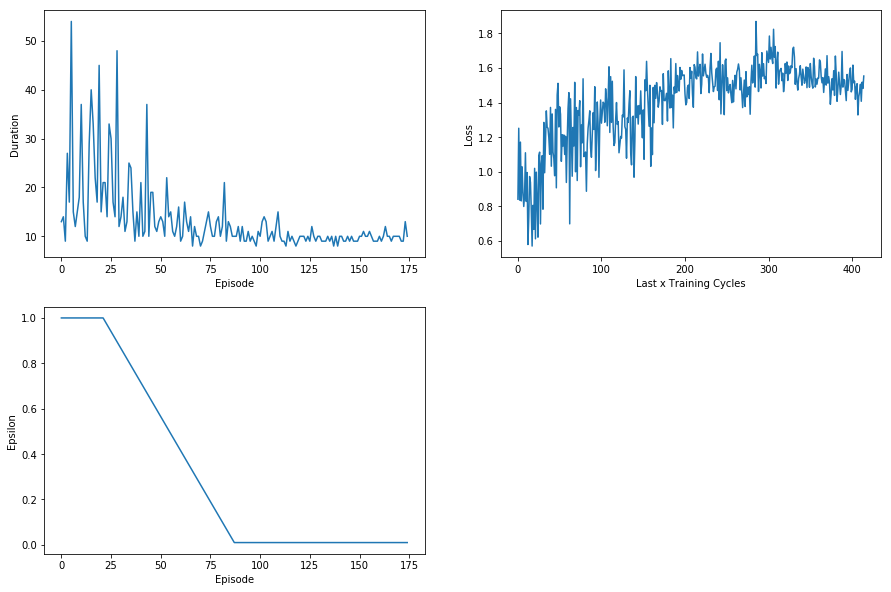

CPU times: user 16.8 s, sys: 13.7 s, total: 30.5 s
Wall time: 10.3 s


In [18]:
import copy
class DQNLinearLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = gym.make("CartPole-v0")
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 100
        
        self.memory = ReplayMemory(capacity=10000)
        self.Q = DQNLinear()
        self.Qt = DQNLinear()
        self.Qt.load_state_dict(self.Q.state_dict())
        self.Q.train()
        self.Qt.train()
        for param in self.Qt.parameters():
            param.requires_grad = False
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s).data.numpy()
        action = np.random.choice([0, 1], p=actions[0])
#         if np.random.rand() > self.epsilon.value():
#             action = np.argmax(actions)
#         else:
#             action = self.env.action_space.sample()
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x, volatile=True).float()
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
#                 if done and episode_reward < 200:
#                     r = 0
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()
                    
                if display is not None and step % 100 == 0:
                    display(self)
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())

        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).long()
        s_1 = Variable(torch.from_numpy(s_1), volatile=True).float()
        r = Variable(torch.from_numpy(r)).float()
        done = Variable(torch.from_numpy(1 - done)).float()
        
        # Q_sa = r + gamma * max(Q_s'a')
        self.Q.reset_noise()
        self.Qt.reset_noise()
        Q = self.Q(s)
#         print("s:", s, "Q:", Q)
        Q = Q.gather(1, a)
#         print("a:", a, "Q:", Q)
        Qt = self.Qt(s_1)
#         print("s_1:", s_1, "Qt:", Qt)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        y.volatile = False #weird

        loss = self.criterion(Q, y)
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
        self.Qt.load_state_dict(self.Q.state_dict())
        self.Qt.train()
#         self.Qt = copy.deepcopy(self.Q)

    def run(self):
        self.env = gym.make("CartPole-v0")
        self.reset()
        self.Q.eval()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
    
env = gym.make("CartPole-v0")
learner = DQNLinearLearner(env, double_Q=True)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

%time learner.train(175, show_chart)

# reward_history = RewardHistory()
# for i in range(10):
#     learner = DQNLinearLearner(double_Q=True)
#     learner.train(175)
#     reward_history.append(learner.episode_rewards)


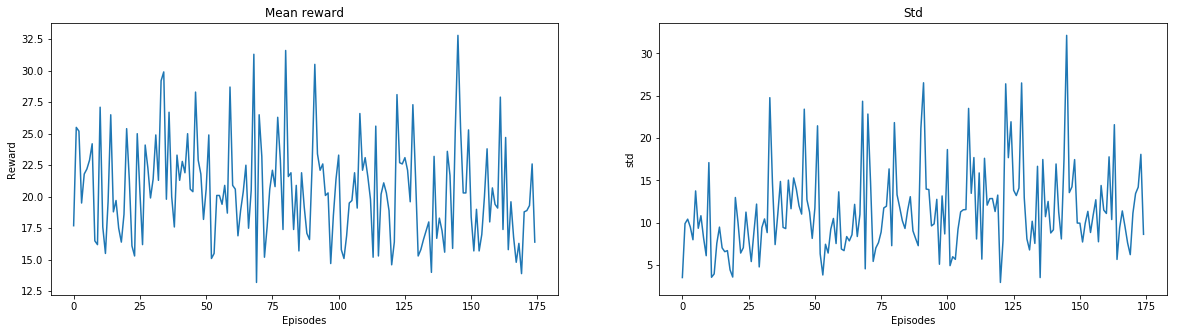

In [87]:
reward_history.plot()

In [ ]:
###### learner.train(100, show_chart)
for i in range(3):
    learner.run()
# display.clear_output(wait=True)

# Lessons Learnt
- Wasted heaps of time forgetting to set s = s_1 after a loop
- Using a MLP (batch 256) with 1 hidden layer of 48 vs 128, the 128 one trained in less than 300 episodes while the 48 gets really wild results
- Using a MLP (batch 256) with 2 hidden layer of 48 will train the network within 500 episodes. Results are somewhat consistent, sometimes it trains even faster than the 128 1 layer MLP. 2 hidden layers of 12 can sometimes still learn in 500 episdoes
- Collecting some data first before training reduces total time required for training. e.g. waiting 1000 steps before training. This is just on observation
- Double Q does seem to have a positive effect on the learning
- Failure reward of -1 didn't seem to make much of a difference. A failure reward of -99 sometimes trains quick, but often wild swings in results
- It seems the magnitude and direction of loss curve doesn't matter much at all, as long as the NN is minimizing the loss as it goes.
- Batch size of 256 vs 64, 256 trains way faster and is much more stable
- F.smooth_l1_loss(Huber Loss) seem to require a higher learning rate 1e-2 and is more unstable. MSE works fine with 1e-3 and is more stable, 1e-2 for MSE trains faster but is less stable

# Mean reward over 100 training sessions
- Deep Q learning
![mean reward](./images/dqn.png)
- Double Q learning
![mean reward](./images/dqn_double.png)
